# Trajectory clustering의 의미
1. 출발지->도착지가 같은 상황의 clustering이면 당연히 cluster는 1개 아닌가? 의미가 있나?  
   *서로다른 출발지 -> 서로다른 도착지의 경로간 비슷한 경로 clustering이 아니고 특징, 패턴탐지를 위해서 함.  
   같은 출발–도착이라도 날아가는 패턴(경로)는 다음 변수에 따라 항상 달라짐.*
   - 이륙 활주로 방향
   - 착륙 활주로 방향
   - 혼잡도
   - 바람 방향
   - 특정 시간대의 쏠림(Arrival Route)
   - SID(Standard Instrument Departure)
   - STAR(Standard Arrival) 절차 선택
   - 특정 구간에서의 회피 회전(avoidance turn)
   <br><br> 
2. 이거완전 다항회귀처럼 여러 데이터를 반영하는 하나의 경로찾기 아닌가?  
   *다수의 곡선들을 ‘형태 기반’으로 그룹화하는 작업. 다항회귀랑은 다름.  
   회귀는 '예측', clustering은 '패턴분류'. 탐색적 작업에 가까움*
   <br><br>
3. 한 줄 요약  
   *곡선 모양(trajectory)을 일정 길이로 샘플링해 벡터로 만들고,  
   곡선 사이의 유사도를 거리 기반으로 계산해  
   HDBSCAN이 밀도 기반으로 패턴을 찾는 것”*
   - 거리계산은 벡터간에만 가능 -> 벡터로 만들기 위해 여러좌표를 모아서 flatten
   - 곡선을 비교하려면 두 곡선이 같은 길이의 point sequence여야 함 -> 벡터간 거리 계산시 x1,y1,z1과 x2,y2를 비교할 수 는 없으니 -> 경로간 좌표개수(차원) 통일 -> resampling or interpolation
   - 근데 곡선간 비교를 위해 왜 flatten 함? -> curve는 본질적으로 고차원 벡터의 한 점이다(위치별 여러 점의 정보가 고차원화되어 그걸 한 점으로 표현된) = 여러 벡터의 합이 아니라 고차원벡터로 인코딩
   - 유사하게 이미지 데이터도 3차원 행렬이지만 연산시 1차원의 flatten해서 진행 = 이미지 자체는 고차원 벡터 하나에 대응됨
   - 따라서 곡선간의 거리 비교도 결국 고차원 벡터 두 점 사이의 거리

## Import library

In [ ]:
!pip install umap-learn

In [ ]:
!pip install "scikit-learn==1.5.2"

In [ ]:
!pip install "protobuf==3.20.*"

In [ ]:
!pip uninstall -y sklearn-compat
!pip uninstall -y imbalanced-learn
!pip uninstall -y category-encoders

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip install umap-learn==0.5.9.post2

In [31]:


import os
import pandas as pd
import xml.etree.ElementTree as ET

from pyproj import Transformer
import numpy as np
import umap
import hdbscan
import matplotlib.pyplot as plt
import folium

## Input day text('Thu') and download all the day tragetory files
* 목표는 최소 50개 이상, 약 100\~200개 이상의 경로수집
* 그럼 주 패턴이 2~4개로 나뉠 것으로 예상
* 부패턴이 나타나기 시작할 것으로 예상
* HDBSCAN이 안정적으로 condensed tree 형성 기대

In [ ]:
# "https://www.flightaware.com/live/findflight?origin=RKSI&destination=RJFF" 진입
# selenium으로 요일 텍스트 'Thu'에 해당하는 링크들 선회
# 클릭해서 새 driver로 전환
# 해당 driver링크 저장 ("https://www.flightaware.com/live/flight/ESR649/history/20251113/0925Z/RKSI/RJFF")
# 위 과정 반복
# 끝나면 url링크 + '/google_earth' 처리 ("https://www.flightaware.com/live/flight/ESR649/history/20251113/0925Z/RKSI/RJFF/google_earth")
# 끝나면 각 링크 순회 -> 파일링크라서 자동 다운로드 됨
# 이후 kaggle dataset에 업로드

## Upload all downloaded files and integrate
> KML : XML 기반, XML은 태그기반의 트리 구조 (HTML처럼)  
> tree → root → child → child … 이런 계층이 존재  
> 다만 화면 표시용이 아닌 데이터를 저장하고 전달하기 위한 언어
> 속성끼리 자연스럽게 묶이고 그룹화되는 구조 표현에 적합
> 계층적 데이터 표현(지도/항공/위치/기업시스템설정), schema를 통한 엄밀한 데이터구조 검증(규격 절대사수: 금융/공공기관), 문서형태의 구조(RSS)에 사용됨
* df 해당날짜의 항공편별(INC-FUK) 데이터  
  flight: 항공편 (*경로마다 기록포인트 개수가 다름*)    
  time: 시각 (*시간은 UTC기준. 홈페이지는 UTC-5(EST, 미국 동부표준시간대)로 나와서 5만큼 차이남*)    
  longitude: 경도  
  latitude: 위도  
  altitude: 고도  

In [3]:
def load_flight_data(folder):
    """
    folder : KML 파일들이 들어 있는 폴더 경로
    return : df
    """
    # folder = "/kaggle/input/flight-trajectory-icn-fuk-20251113"
    
    df_list = []
    
    ns = {
        "k": "http://www.opengis.net/kml/2.2",
        "gx": "http://www.google.com/kml/ext/2.2"
    } # namespace = 태그의 포인터, 태그이름 같아도 구별필요. 접근용 식별자

    # 폴더 내 모든 파일 순회
    for fname in os.listdir(folder):
        fpath = os.path.join(folder, fname)

        print(f"Processing: {fname}...")
        tree = ET.parse(fpath)
        root = tree.getroot()

        placemarks = root.findall(".//k:Placemark", ns)

        # 경로있는 placemark 탐색
        track_pm = None
        for pm in placemarks:
            track = pm.find("gx:Track", ns)
            if track is not None:
                track_pm = track
                flight = pm.find("k:name", ns).text
                break

        if track_pm is None:
            raise ValueError(f"경로정보를 찾을 수 없습니다: {fname}") # 강제 에러발생

        # 경로정보 추출
        whens = [w.text for w in track_pm.findall("k:when", ns)]
        coords = [c.text for c in track_pm.findall("gx:coord", ns)]

        flight_id = f"{flight}_{whens[0]}"
        rows = []
        for when, coord in zip(whens, coords):
            when = when.replace("T", " ").replace("Z", "") # 2025-11-13T07:10:08Z
            time = pd.to_datetime(when)
            lon, lat, alt = coord.split()
            rows.append([flight_id, time, float(lon), float(lat), float(alt)])

        df_temp = pd.DataFrame(rows, 
                               columns=['flight_id', 'time', 'longitude', 'latitude', 'altitude'])
        df_list.append(df_temp)

    df = pd.concat(df_list, ignore_index=True) # 기존 index를 무시하고 새로 부여. concat에서는 거의 필수
    print("변환작업 완료!")
    
    return df

In [ ]:
folder = "/kaggle/input/flight-trajectory-icn-fuk-20251113"
df = load_flight_data(folder)

In [ ]:
# 파일로 저장

date = folder.split("/")[-1].split("-")[-1] # 예: "20251113"
df.to_csv(f"flight_data_{date}.csv", index=False, encoding="utf-8")

## Preprocessing
* 좌표계 변환 (lat/lon->Euclid 공간): UTM(Universal Transverse Mercator), local ENU로 변환하는 편
  * UTM (Universal Transverse Mercator): 지구 전체를 6° 단위 zone으로 나눔, 평면좌표로 투영, meter 단위, 왜곡이 작고 안정적
  * ENU (East-North-Up): 기준점(Reference point)을 하나 잡고 그 점을 0,0,0으로 두는 국소 좌표, 특정 지역, 작은 영역에서 매우 정밀, 자율주행 같이 국소지역에 강점
* flight 단위로 grouping
* noise 제거: speed-based filtering(속도기반 제거, 속도가 갑자기 뛴다), Hampel filter(평균말고 중앙값기반으로 outlier 판별 및 대체), Kalman filter(정확도 좋음)
* 경로별 arc-length resampling(곡선길이 조정): sequence, 즉 좌표개수 통일하는 과정
  * 좌표간 거리 계산
  * 누적거리 계산 -> 비행 전체의 진행률 확인용
  * 전체경로함수 f(t)=(x(t),y(t),z(t)) 에서 t를 0~1로 normalization
  * 일정 진행률 별로 좌표 interpolation
  * 모든 경로에 대해서 좌표개수 통일
* 벡터로 flatten
* UMAP dimensionality reduction
---
1. UTM변환: lat, lon만 지구곡면 위 각도(구면좌표계)라서 보정(평면좌표계). alt는 괜찮음
2. Hampel filter적용

### data load

In [4]:
folder = "/kaggle/input/flight-trajectory-icn-fuk-20251112"
df_251112 = load_flight_data(folder)

Processing: FlightAware_TWB201_RKSI_RJFF_20251112.kml...
Processing: FlightAware_ASV727_RKSI_RJFF_20251112.kml...
Processing: FlightAware_JNA269_RKSI_RJFF_20251112.kml...
Processing: FlightAware_TWB205_RKSI_RJFF_20251112.kml...
Processing: FlightAware_JJA1407_RKSI_RJFF_20251112.kml...
Processing: FlightAware_JNA261_RKSI_RJFF_20251111.kml...
Processing: FlightAware_JJA1405_RKSI_RJFF_20251112.kml...
Processing: FlightAware_KAL787_RKSI_RJFF_20251111.kml...
Processing: FlightAware_ESR647_RKSI_RJFF_20251112.kml...
Processing: FlightAware_ESR649_RKSI_RJFF_20251112.kml...
Processing: FlightAware_ABL156_RKSI_RJFF_20251111.kml...
Processing: FlightAware_JJA1403_RKSI_RJFF_20251112.kml...
Processing: FlightAware_AAR134_RKSI_RJFF_20251112.kml...
Processing: FlightAware_ESR645_RKSI_RJFF_20251111.kml...
Processing: FlightAware_ASV723_RKSI_RJFF_20251111.kml...
Processing: FlightAware_TWB207_RKSI_RJFF_20251112.kml...
Processing: FlightAware_JNA265_RKSI_RJFF_20251112.kml...
Processing: FlightAware_KAL7

In [5]:
df_251112.head()

,flight_id,time,longitude,latitude,altitude
0,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:24,126.45264,37.46356,8.0
1,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:40,126.46169,37.45464,198.0
2,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:57,126.47443,37.44685,389.0
3,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:03:13,126.48787,37.43948,556.0
4,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:03:29,126.49903,37.43182,686.0


In [6]:
df_251112.shape

(2878, 5)

In [7]:
folder = "/kaggle/input/flight-trajectory-icn-fuk-20251113"
df_251113 = load_flight_data(folder)

Processing: FlightAware_JJA1407_RKSI_RJFF_20251113.kml...
Processing: FlightAware_TWB201_RKSI_RJFF_20251113.kml...
Processing: FlightAware_ESR647_RKSI_RJFF_20251113.kml...
Processing: FlightAware_ASV723_RKSI_RJFF_20251112.kml...
Processing: FlightAware_ABL158_RKSI_RJFF_20251113.kml...
Processing: FlightAware_JJA1403_RKSI_RJFF_20251113.kml...
Processing: FlightAware_JNA261_RKSI_RJFF_20251112.kml...
Processing: FlightAware_JJA1401_RKSI_RJFF_20251112.kml...
Processing: FlightAware_ABL156_RKSI_RJFF_20251112.kml...
Processing: FlightAware_KAL781_RKSI_RJFF_20251113.kml...
Processing: FlightAware_JNA269_RKSI_RJFF_20251113.kml...
Processing: FlightAware_TWB205_RKSI_RJFF_20251113.kml...
Processing: FlightAware_ASV727_RKSI_RJFF_20251113.kml...
Processing: FlightAware_KAL791_RKSI_RJFF_20251113.kml...
Processing: FlightAware_JNA263_RKSI_RJFF_20251113.kml...
Processing: FlightAware_AAR134_RKSI_RJFF_20251113.kml...
Processing: FlightAware_KAL787_RKSI_RJFF_20251112.kml...
Processing: FlightAware_TWB2

In [8]:
df_251113.shape

(3048, 5)

In [9]:
train = pd.concat([df_251112, df_251113])

In [10]:
train.shape

(5926, 5)

### UTM 변환
* zone = int((lon + 180) / 6) + 1
* 서울(ICN) → 경도 126 → zone 52N  
  후쿠오카(FUK) → 경도 130 → zone 52N
* 둘 다 같은 zone에 있으므로 문제 없음

In [11]:
train.head()

,flight_id,time,longitude,latitude,altitude
0,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:24,126.45264,37.46356,8.0
1,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:40,126.46169,37.45464,198.0
2,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:57,126.47443,37.44685,389.0
3,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:03:13,126.48787,37.43948,556.0
4,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:03:29,126.49903,37.43182,686.0


In [12]:
# UTM 변환기 설정 (ICN~FUK는 UTM 52N zone이 안정적)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32652", always_xy=True)

# lat/lon → UTM x,y 변환
utm_x = []
utm_y = []

for lon, lat in zip(train["longitude"], train["latitude"]):
    x, y = transformer.transform(lon, lat)
    utm_x.append(x)
    utm_y.append(y)

train["utm_x"] = utm_x
train["utm_y"] = utm_y

In [13]:
train.head()

,flight_id,time,longitude,latitude,altitude,utm_x,utm_y
0,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:24,126.45264,37.46356,8.0,274709.805784,4.149346e+06
1,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:40,126.46169,37.45464,198.0,275483.642857,4.148335e+06
2,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:02:57,126.47443,37.44685,389.0,276587.516339,4.147440e+06
3,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:03:13,126.48787,37.43948,556.0,277754.807436,4.146590e+06
4,TWB201_2025-11-12T02:02:24Z,2025-11-12 02:03:29,126.49903,37.43182,686.0,278719.716208,4.145714e+06


### grouping

In [14]:
trajectories = {}

for fid, group in train.groupby("flight_id"): # groupby로 묶고서 key값인 fid(flight id)와 그룹값 반환
    # 시간순 정렬
    group = group.sort_values("time")

    # trajectory = list of (x, y, altitude)
    coords = list(zip(group["utm_x"], group["utm_y"], group["altitude"]))

    trajectories[fid] = coords

In [15]:
trajectories.keys()

dict_keys(['AAR134_2025-11-12T04:36:25Z', 'AAR134_2025-11-13T04:56:02Z', 'ABL156_2025-11-11T22:36:09Z', 'ABL156_2025-11-12T22:31:07Z', 'ABL158_2025-11-12T02:30:12Z', 'ABL158_2025-11-13T02:31:05Z', 'ASV723_2025-11-11T23:26:12Z', 'ASV723_2025-11-12T22:33:15Z', 'ASV727_2025-11-12T07:21:31Z', 'ASV727_2025-11-13T07:06:59Z', 'ESR645_2025-11-12T00:01:41Z', 'ESR645_2025-11-12T23:56:03Z', 'ESR647_2025-11-12T03:52:54Z', 'ESR647_2025-11-13T03:38:36Z', 'ESR649_2025-11-12T09:23:57Z', 'ESR649_2025-11-13T10:04:24Z', 'JJA1401_2025-11-11T21:53:17Z', 'JJA1401_2025-11-12T21:46:07Z', 'JJA1403_2025-11-12T02:06:12Z', 'JJA1403_2025-11-13T01:49:44Z', 'JJA1405_2025-11-12T06:27:51Z', 'JJA1405_2025-11-13T06:35:36Z', 'JJA1407_2025-11-12T07:31:12Z', 'JJA1407_2025-11-13T07:53:11Z', 'JNA261_2025-11-11T22:02:10Z', 'JNA261_2025-11-12T22:04:54Z', 'JNA263_2025-11-12T03:12:34Z', 'JNA263_2025-11-13T03:19:12Z', 'JNA265_2025-11-12T09:10:07Z', 'JNA265_2025-11-13T08:37:02Z', 'JNA269_2025-11-12T05:18:12Z', 'JNA269_2025-11-13T0

In [16]:
len(trajectories.keys())

44

In [17]:
trajectories['AAR134_2025-11-12T04:36:25Z']

[(274231.4644269148, 4150051.933865771, 0.0),
 (274968.2443317637, 4148951.4479752635, 91.0),
 (275732.03218737856, 4147925.8306583837, 305.0),
 (276689.69218774233, 4146990.602934243, 488.0),
 (277762.7858755584, 4146092.4005301883, 686.0),
 (278780.47090647265, 4145266.89439211, 899.0),
 (279941.5790112573, 4144331.137331857, 991.0),
 (281501.55836638727, 4143024.2096969625, 1105.0),
 (283004.5071451625, 4141720.203631306, 1196.0),
 (285347.68303955713, 4139615.3582184985, 1410.0),
 (286603.7735872078, 4137898.7110972176, 1448.0),
 (287357.7895871515, 4135381.143369552, 1608.0),
 (288618.65547986014, 4131140.9222074123, 2035.0),
 (289771.83925202955, 4129200.995938245, 2263.0),
 (292196.1537571751, 4127828.1315649305, 2515.0),
 (294661.48983146006, 4127737.4061098383, 2743.0),
 (297524.82649494655, 4127998.623072507, 3018.0),
 (302253.3541324694, 4128211.041922448, 3208.0),
 (308016.34190098604, 4128371.2626622636, 3459.0),
 (311295.7952380425, 4127697.3030844615, 3673.0),
 (314612.3

### noise 제거

In [ ]:
'''
def hampel_filter_1d(x, window_size=5, n_sigmas=3):
    n = len(x)
    x_new = x.copy()
    k = 1.4826  # scale factor for Gaussian distribution

    for i in range(window_size, n - window_size):
        window = x[(i - window_size):(i + window_size)]
        median = np.median(window)
        mad = k * np.median(np.abs(window - median))

        if np.abs(x[i] - median) > n_sigmas * mad:
            x_new[i] = median

    return x_new
'''

In [ ]:
'''
filtered_trajectories = {}

for fid, coords in trajectories.items():
    xs = np.array([p[0] for p in coords])
    ys = np.array([p[1] for p in coords])
    zs = np.array([p[2] for p in coords])

    xs_f = hampel_filter_1d(xs)
    ys_f = hampel_filter_1d(ys)
    zs_f = hampel_filter_1d(zs)

    filtered_trajectories[fid] = list(zip(xs_f, ys_f, zs_f))
'''

### arc-length resampling

In [18]:
# Euclid 거리 계산
def euclid_dist(p1, p2):
    # p1=(x1,y1,z1), p2=(x2,y2,z2)
    return np.sqrt(
        (p1[0] - p2[0])**2 +
        (p1[1] - p2[1])**2 +
        (p1[2] - p2[2])**2
    )

In [19]:
# 전체 거리대비 진행율 계산
def arc_length_progress(coords):
    # coords: list of (x,y,z)
    n = len(coords)
    dists = np.zeros(n)

    # 점 사이 거리 계산
    for i in range(1, n):
        dists[i] = euclid_dist(coords[i], coords[i-1])

    # 누적합 함수: [2,3,5] -> [2,5,10]
    cumdist = np.cumsum(dists)

    # normalize to [0,1]
    total = cumdist[-1]
    if total == 0:
        return cumdist  # degenerate case (all points identical)
    
    progress = cumdist / total
    return progress

In [20]:
# interpolation: lat, lon, alt 각각 진행
def interp_1d(new_locations, origianl_locations, original_values):
    # numpy.interp: new_locations 기준으로 보간. 기존 값들의 위치와 수치를 가지고
    return np.interp(new_locations, origianl_locations, original_values)

In [21]:
# resampling 함수
def arc_length_resample(coords, N=100):
    """
    coords : list of (x,y,z)
    N      : number of resampled points
    """
    coords = np.array(coords)    # shape (L,3)
    xs, ys, zs = coords[:,0], coords[:,1], coords[:,2]

    # 1. progress t (0~1) 구하기
    progress = arc_length_progress(coords)

    # 2. 목표 t값 (0~1에서 균일)
    uniform_t = np.linspace(0, 1, N) # 균일 분할함수 linspace(시작값,끝값,개수)

    # 3. interpolation
    xs_new = interp_1d(uniform_t, progress, xs) # 균등 거리지점의 값(uniform_t)들로 보간, 기존 데이터(xs)와 위치(progress)를 참고해서 
    ys_new = interp_1d(uniform_t, progress, ys)
    zs_new = interp_1d(uniform_t, progress, zs)

    # 4. 결과 결합
    resampled = list(zip(xs_new, ys_new, zs_new))
    return resampled


In [22]:
resampled_trajectories = {}

for fid, coords in trajectories.items():
    resampled = arc_length_resample(coords, N=100)
    resampled_trajectories[fid] = resampled

In [23]:
resampled_trajectories['AAR134_2025-11-12T04:36:25Z']

[(274231.4644269148, 4150051.933865771, 0.0),
 (278275.5083213579, 4145676.5002139993, 793.3120637896991),
 (282909.6371260173, 4141802.5158711914, 1190.2558443347311),
 (286789.07586088637, 4137280.0093400786, 1487.3206029988623),
 (288512.8598224567, 4131496.707059694, 1999.1716490449091),
 (292811.7389453863, 4127805.477758445, 2571.9307464309395),
 (298832.45606511063, 4128057.3654952515, 3070.5427019522153),
 (304879.9863370035, 4128284.066709579, 3322.3998061109446),
 (310867.5182995472, 4127785.318163496, 3645.0528833868825),
 (315399.30189027224, 4124021.550197947, 4037.5678683857514),
 (318482.56855673075, 4118817.801100988, 4361.0549143847575),
 (321539.1555217367, 4113601.674170022, 4733.080282604395),
 (324484.81091647694, 4108317.489228536, 5016.308272628994),
 (327439.0979020399, 4103035.317590767, 5258.743844326884),
 (330509.1338838783, 4097821.9443176906, 5542.037526348918),
 (333618.9341261688, 4092632.5915154093, 5841.901171106126),
 (337248.66700423334, 4087828.7274

### flatten

In [24]:
flat_resamp_traj = {}

for fid, coords in resampled_trajectories.items():
    matrix = np.array(coords)
    vec = matrix.flatten()
    flat_resamp_traj[fid] = vec

In [25]:
flat_resamp_traj['AAR134_2025-11-12T04:36:25Z']

array([ 2.74231464e+05,  4.15005193e+06,  0.00000000e+00,  2.78275508e+05,
        4.14567650e+06,  7.93312064e+02,  2.82909637e+05,  4.14180252e+06,
        1.19025584e+03,  2.86789076e+05,  4.13728001e+06,  1.48732060e+03,
        2.88512860e+05,  4.13149671e+06,  1.99917165e+03,  2.92811739e+05,
        4.12780548e+06,  2.57193075e+03,  2.98832456e+05,  4.12805737e+06,
        3.07054270e+03,  3.04879986e+05,  4.12828407e+06,  3.32239981e+03,
        3.10867518e+05,  4.12778532e+06,  3.64505288e+03,  3.15399302e+05,
        4.12402155e+06,  4.03756787e+03,  3.18482569e+05,  4.11881780e+06,
        4.36105491e+03,  3.21539156e+05,  4.11360167e+06,  4.73308028e+03,
        3.24484811e+05,  4.10831749e+06,  5.01630827e+03,  3.27439098e+05,
        4.10303532e+06,  5.25874384e+03,  3.30509134e+05,  4.09782194e+06,
        5.54203753e+03,  3.33618934e+05,  4.09263259e+06,  5.84190117e+03,
        3.37248667e+05,  4.08782873e+06,  6.14093043e+03,  3.42253309e+05,
        4.08444747e+06,  

### dimensionality reduction: UMAP
<!-- 현재상태
flat_vectors = {
    'A001': array([...300 dims...]),
    'A002': array([...300 dims...]),
    'A003': array([...]),
    ...
} -->

In [26]:
# dict -> matrix

fids = list(flat_resamp_traj.keys())
X = np.vstack([flat_resamp_traj[fid] for fid in fids])

In [27]:
X.shape

(44, 300)

In [28]:
umap_model = umap.UMAP(
    n_components=5, # trajectory clustering에서는 보통 5~10 사용
    n_neighbors=15, # local structure 반영
    min_dist=0.1, 
    metric="euclidean" # flatten vector이므로 Euclidean 가능
)

X_emb = umap_model.fit_transform(X)

## Clustering

In [29]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,        
    min_samples=5,             
    cluster_selection_epsilon=0.0,
    metric='euclidean'
)

labels = clusterer.fit_predict(X_emb)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


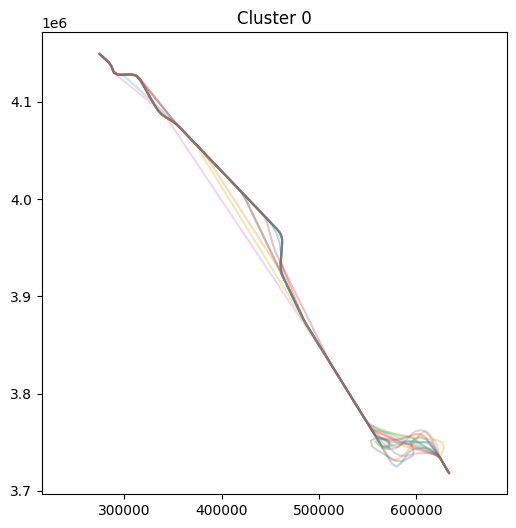

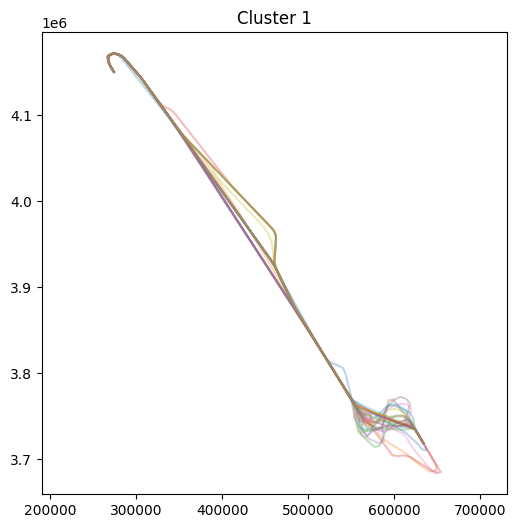

In [30]:
# 시각화

for cluster_id in set(labels):
    if cluster_id == -1:
        continue

    plt.figure(figsize=(6,6))

    for fid, lbl in zip(fids, labels):
        if lbl == cluster_id:
            traj = resampled_trajectories[fid]   # 이미 N개의 (x,y,z)
            xs = [p[0] for p in traj]
            ys = [p[1] for p in traj]
            plt.plot(xs, ys, alpha=0.3)

    plt.title(f"Cluster {cluster_id}")
    plt.axis('equal')
    plt.show()


In [33]:
# 지도로 시각화

# UTM 52N → WGS84
to_wgs84 = Transformer.from_crs("EPSG:32652", "EPSG:4326", always_xy=True)

def utm_to_latlon(x, y):
    lon, lat = to_wgs84.transform(x, y)
    return lat, lon

latlon_trajs = {}

for fid, traj in resampled_trajectories.items():
    latlon = [utm_to_latlon(p[0], p[1]) for p in traj]
    latlon_trajs[fid] = latlon

# 지도 초기화 (대략 중간 위치)
m = folium.Map(location=[35, 130], zoom_start=5)

for cluster_id in set(labels):
    if cluster_id == -1:
        continue

    # cluster members
    cluster_members = [
        fid for fid, lbl in zip(fids, labels) if lbl == cluster_id
    ]

    # folium polyline 색 or 투명도 다르게 설정 가능
    for fid in cluster_members:
        traj = latlon_trajs[fid]   # [(lat, lon), ... ]
        folium.PolyLine(
            traj,
            color="red",
            weight=2,
            opacity=0.4
        ).add_to(m)

m